In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib import animation
from salishsea_tools.nc_tools import scDataset
from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/upwelling_depth/')
import upwelling_functions

import warnings
warnings.filterwarnings("ignore")

import time
from datetime import datetime 

/home/imachuca/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
def define_files():
    fname = '1_MCKNZ_1h_20170101_201701*'
    meshmaskname = '1_mesh_mask.nc'

    vosaline_ref = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/conditions/NEMO_files/salinity/salinity_for_agrif.nc')['vosaline'][:]
    vosaline_ref_profile = vosaline_ref[0, :, 0, 0]
    
    return fname, meshmaskname, vosaline_ref_profile

In [ ]:
def get_depth_upwelled(dirname, dep_ind_slice, time_s):
    
    fname, meshmaskname, vosaline_ref_profile = define_files()
    
    time_f = time_s+24

    vosaline, sozotaux, deptht, tmask = upwelling_functions.get_vars_salt(dirname, fname, meshmaskname, dep_ind_slice, time_s, time_f, None)

    vosaline_daily = upwelling_functions.get_daily_vosaline(vosaline, tmask, None)

    depth_ind_daily = upwelling_functions.get_daily_depth_ind(vosaline_daily, vosaline_ref_profile)
    depth_m_daily, depth_upwelled = upwelling_functions.get_daily_depth_m(deptht, dep_ind_slice, depth_ind_daily, tmask)
    
    return depth_upwelled

# Ideal

In [ ]:
kind = 'ideal'
case = 'base'
dirname = '/ocean/imachuca/Canyons/results_mackenzie/extended_domain/'+kind+'_'+case+'/'

In [3]:
time_s_day1 = 24*0+11 # day 1
time_s_day2 = 24*1+11 # day 2
time_s_day5 = 24*4+11 # day 5

dep_ind_slice = 9
depth_upwelled_A = get_depth_upwelled(dirname, dep_ind_slice, time_s_day1)
depth_upwelled_B = get_depth_upwelled(dirname, dep_ind_slice, time_s_day2)
depth_upwelled_C = get_depth_upwelled(dirname, dep_ind_slice, time_s_day5)
print(dep_ind_slice)

dep_ind_slice = 11
depth_upwelled_D = get_depth_upwelled(dirname, dep_ind_slice, time_s_day1)
depth_upwelled_E = get_depth_upwelled(dirname, dep_ind_slice, time_s_day2)
depth_upwelled_F = get_depth_upwelled(dirname, dep_ind_slice, time_s_day5)
print(dep_ind_slice)

dep_ind_slice = 18
depth_upwelled_G = get_depth_upwelled(dirname, dep_ind_slice, time_s_day1)
depth_upwelled_H = get_depth_upwelled(dirname, dep_ind_slice, time_s_day2)
depth_upwelled_I = get_depth_upwelled(dirname, dep_ind_slice, time_s_day5)
print(dep_ind_slice)

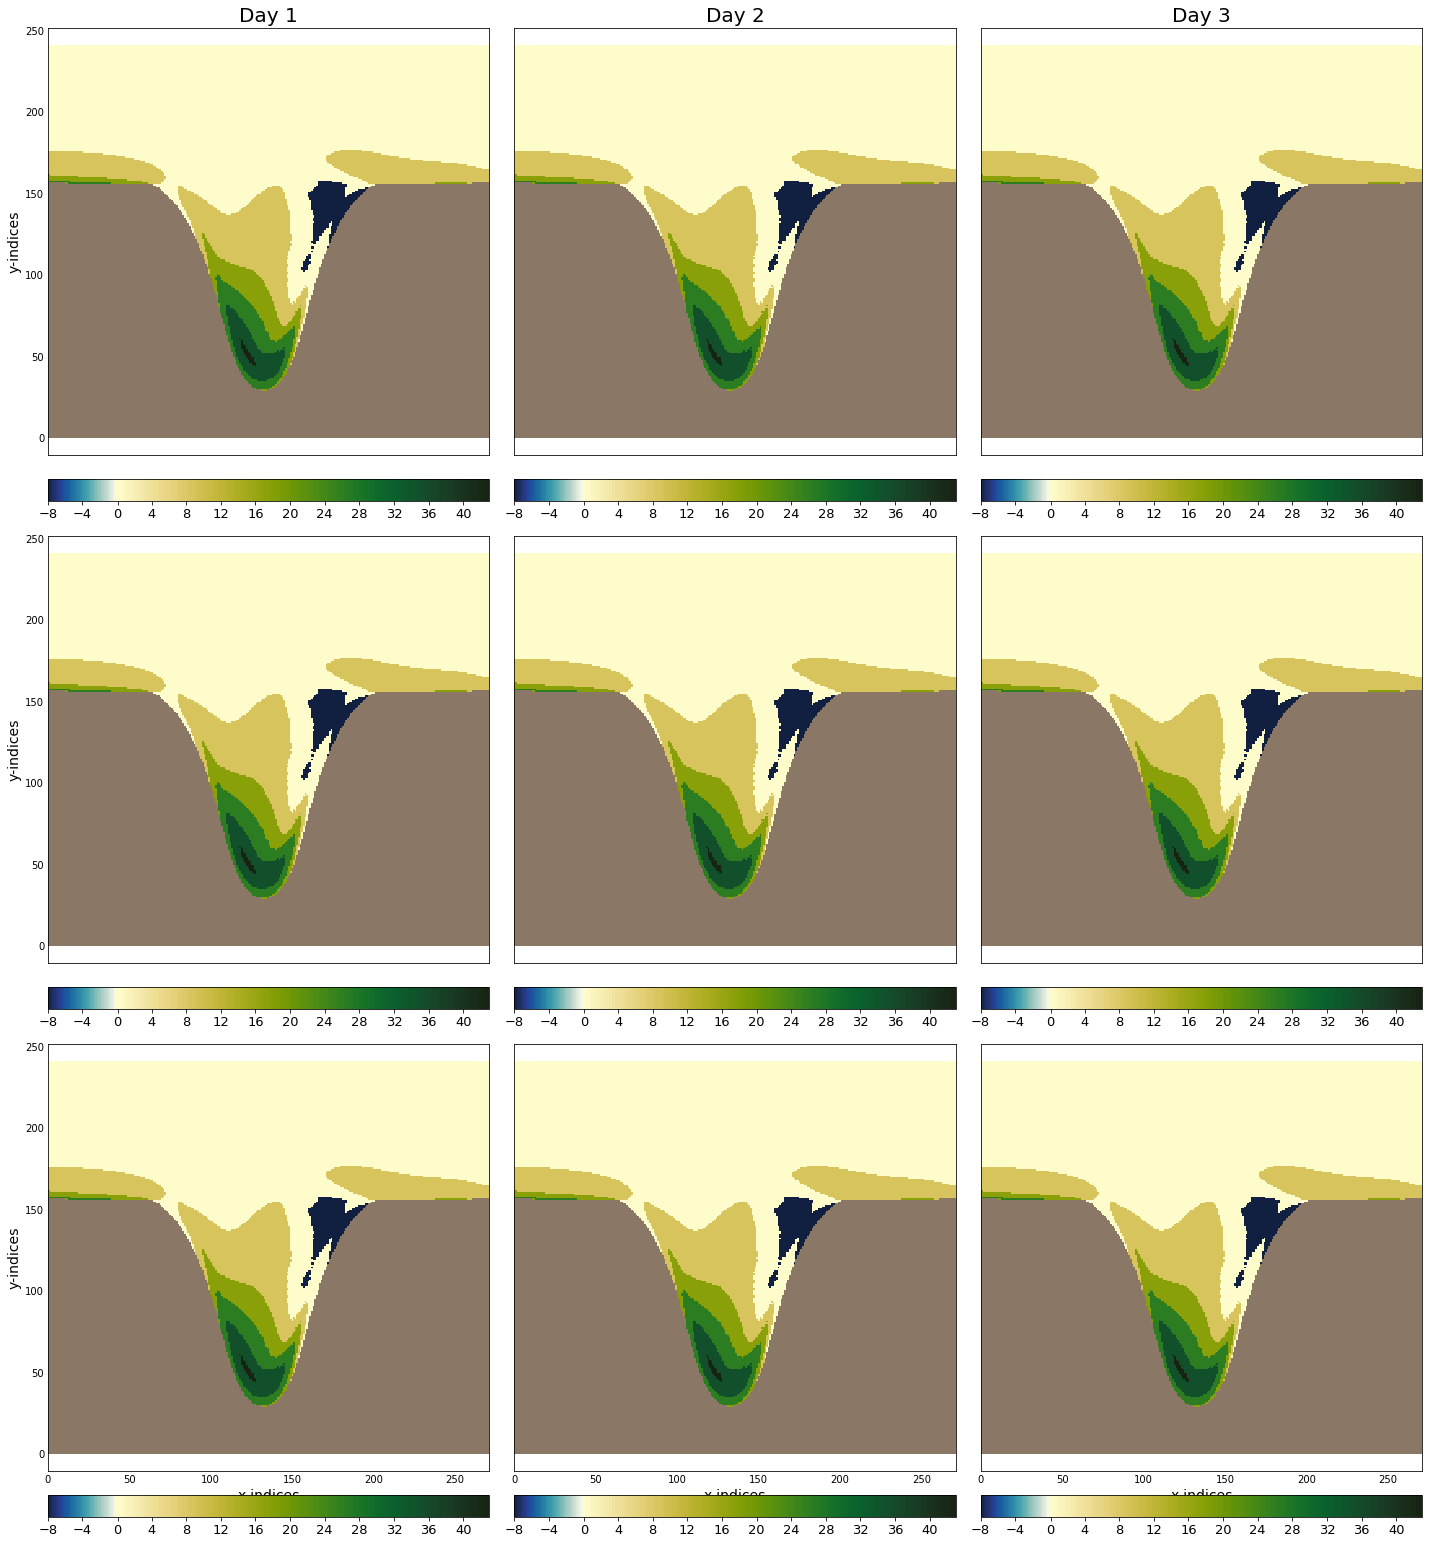

In [59]:
cmap, norm = cmo.cm.delta, upwelling_functions.MidpointNormalize(midpoint=0)
cmap.set_bad('#8b7765')
vmin, vmax = int(np.min(depth_upwelled)), int(np.max(depth_upwelled))
xs = np.arange(tmask.shape[-1])
ys = np.arange(tmask.shape[-2])

fig, axes = plt.subplots(3, 3, figsize=(20, 22), sharex=True, sharey=True)

for ax, n in zip(axes.flatten(), np.arange(9)):
    p = ax.pcolormesh(xs, ys, depth_upwelled, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm)
    #plt.setp(ax.get_xticklabels(), visible=False)
    #plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_aspect(aspect='equal')
    ax.set_xlim([0, xs[-1]])
    ax.set_ylim([0, ys[-1]])
    cbar = fig.colorbar(p, ax=ax, fraction=0.052, orientation='horizontal', pad=0.05)
    cbar.ax.tick_params(labelsize=13)
    tick_locator = ticker.MaxNLocator(nbins=15)
    cbar.locator = tick_locator
    cbar.update_ticks()
    
    if n==0: ax.set_title('Day 1', fontsize=20)
    elif n==1: ax.set_title('Day 2', fontsize=20)
    elif n==2: ax.set_title('Day 3', fontsize=20)
    else: pass
    
    if n==0 or n==3 or n==6: ax.set_ylabel('y-indices', fontsize=14)
    else: pass
    
    if n==6 or n==7 or n==8: ax.set_xlabel('x-indices', fontsize=14)
    else: pass

fig.tight_layout(w_pad=1.2, h_pad=1.2)
plt.subplots_adjust(top=0.96)